In [ ]:
import polars as pl
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import os
from datasets import Dataset
from google.colab import files
import shutil
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import transformers
import pandas as pd
import kagglehub


In [ ]:
path = kagglehub.dataset_download("saurabhshahane/fake-news-classification")
news_dataset_path = os.path.join(path, "WELFake_Dataset.csv")
df_news = pl.read_csv(news_dataset_path)

Using Colab cache for faster access to the 'fake-news-classification' dataset.


In [44]:
df_news = df_news[~df_news['text'].isna()]

In [45]:
df_news.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [5]:
df_news.size

288380

In [46]:
df = df_news

In [47]:
df.shape

(72095, 4)

In [ ]:
def clean_text(text):
    if "(Reuters)" in text:
        try:
            return text.split(" - ", 1)[1]
        except:
            return text
    return text

df['text'] = df['text'].apply(clean_text)

In [50]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [51]:
df.head()

,Unnamed: 0,title,text,label
0,44395,"Trump Tweets Deranged, Self-Congratulatory ‘F...",Trump s ongoing meltdown over fake news (the...,1
1,53213,Rio Olympics: Drama in the Pool and a Super Tu...,Women’s Breaststroke: In the days leading up...,0
2,10100,4 DEAD TEENAGERS In Two Weeks…Illegal Immigran...,It was only a matter of time We can t keep our...,1
3,48043,It’s Not Just Fox: Why Women Don’t Report Sexu...,A male colleague grabbing her leg. Another one...,0
4,25213,EU Parliament names press room after murdered ...,The European Parliament named its press room i...,0


In [ ]:
BASE_DIR = "/content"

DATA_DIR = os.path.join(BASE_DIR, "data")
DB_PATH = os.path.join(DATA_DIR, "logs.db")
MODEL_PATH = os.path.join(BASE_DIR, "models", "distilbert_fake_news")

BASE_MODEL = "distilbert-base-uncased"
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 3

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

print("BASE_DIR:", BASE_DIR)
print("DATA_DIR:", DATA_DIR)
print("MODEL_PATH:", MODEL_PATH)


BASE_DIR: /content
DATA_DIR: /content/data
MODEL_PATH: /content/models/distilbert_fake_news


In [54]:
df.to_csv("data/main_df.csv")

In [ ]:
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])

        return item

    def __len__(self):
        return len(self.labels)


In [ ]:
csv_path = os.path.join(DATA_DIR, "main_df.csv")
print("Loading data with Polars...")
df = pl.read_csv(csv_path)

texts = df["text"].to_list()
labels = df["label"].to_list()

train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2)

Loading data with Polars...


In [ ]:
print("Tokenizing data...")
tokenizer = DistilBertTokenizer.from_pretrained(BASE_MODEL)

Tokenizing data...


In [ ]:
train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels})

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

train_dataset = train_dataset.map(tokenize_fn, batched=True, num_proc=4)
val_dataset = val_dataset.map(tokenize_fn, batched=True, num_proc=4)

train_dataset.set_format("torch")
val_dataset.set_format("torch")

Map (num_proc=4):   0%|          | 0/57676 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/14419 [00:00<?, ? examples/s]

In [ ]:
print("Model loading...")
model = DistilBertForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=2)

Model loading...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,                   
    per_device_train_batch_size=16,       
    per_device_eval_batch_size=32,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="no",             
    save_strategy="no",                   
    fp16=True,
    metric_for_best_model="eval_loss",
    load_best_model_at_end=True,                   
)


In [65]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

print("Starting training...")
trainer.train()

print(f"Saving model to {MODEL_PATH}...")
model.save_pretrained(MODEL_PATH)
tokenizer.save_pretrained(MODEL_PATH)
print("Training complete!")

Starting training...


Step,Training Loss
50,0.082300
100,0.062600
150,0.039900
200,0.047400
250,0.036200
300,0.042200
350,0.030900
400,0.057200
450,0.068900
500,0.021400


Saving model to /content/models/distilbert_fake_news...
Training complete!


In [ ]:
shutil.make_archive("models_concat", 'zip', "models")
files.download("models_concat.zip")


'/content/models_concat.zip'

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
print("Predicting on validation set...")
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids


Predicting on validation set...



Звіт моделі:
               precision    recall  f1-score   support

Fake News (0)       0.98      0.99      0.99      6995
Real News (1)       0.99      0.98      0.99      7424

     accuracy                           0.99     14419
    macro avg       0.99      0.99      0.99     14419
 weighted avg       0.99      0.99      0.99     14419



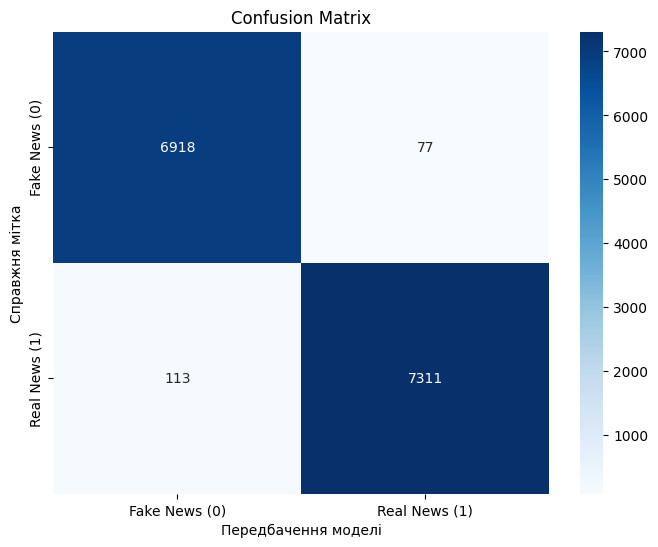

In [ ]:
print("\nЗвіт моделі:")
target_names = ['Fake News (0)', 'Real News (1)']
print(classification_report(true_labels, preds, target_names=target_names))

cm = confusion_matrix(true_labels, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Справжня мітка')
plt.xlabel('Передбачення моделі')
plt.title('Confusion Matrix')
plt.show()

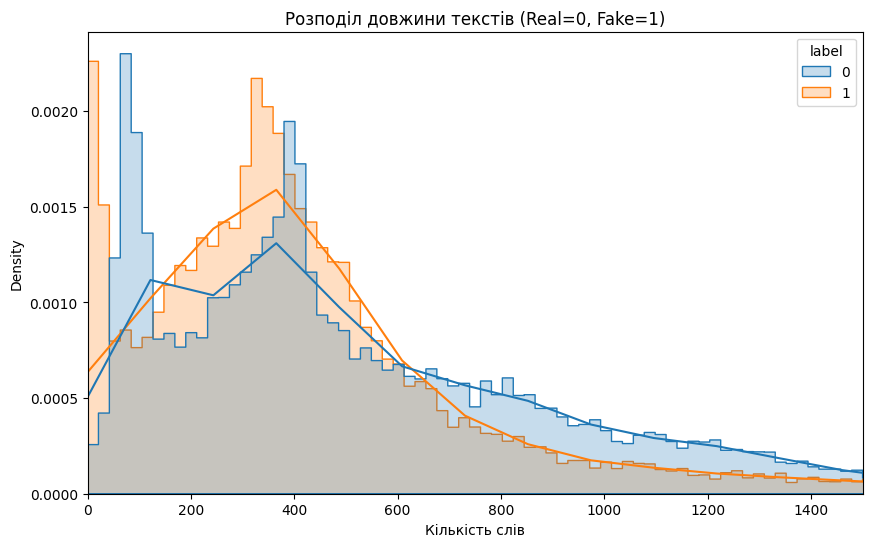

In [ ]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    if "(Reuters)" in text:
        try:
            return text.split(" - ", 1)[1]
        except IndexError:
            return text
    return text

df = df.with_columns([
    pl.Series("text_clean", [clean_text(x) for x in df["text"]]),
])

df = df.with_columns([
    pl.Series("text_len", [len(x.split()) for x in df["text_clean"]]),
])

df_pd = df.to_pandas()

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_pd,
    x='text_len',
    hue='label',
    kde=True,
    element="step",
    stat="density",
    common_norm=False
)
plt.title('Розподіл довжини текстів (Real=0, Fake=1)')
plt.xlim(0, 1500)
plt.xlabel('Кількість слів')
plt.show()


In [ ]:
df = df.with_columns(
    pl.col("label").cast(pl.Int32)
)

real_text_list = df.filter(pl.col("label") == 1)["text_clean"].to_list()
fake_text_list = df.filter(pl.col("label") == 0)["text_clean"].to_list()


In [78]:
real_text = " ".join(real_text_list)
fake_text = " ".join(fake_text_list)

plt.figure(figsize=(16, 8))

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

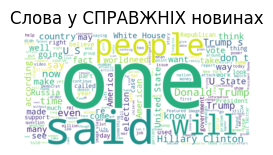

In [ ]:
if len(real_text) > 0:
    wc_real = WordCloud(width=800, height=400, background_color='white').generate(real_text)
    plt.subplot(1, 2, 1)
    plt.imshow(wc_real, interpolation='bilinear')
    plt.title('Слова у СПРАВЖНІХ новинах')
    plt.axis('off')


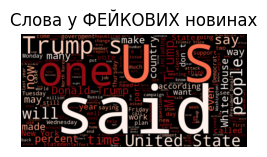

In [ ]:
if len(fake_text) > 0:
    wc_fake = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(fake_text)
    plt.subplot(1, 2, 2)
    plt.imshow(wc_fake, interpolation='bilinear')
    plt.title('Слова у ФЕЙКОВИХ новинах')
    plt.axis('off')

plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text_clean'], df['label'], test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('clf', LogisticRegression())
])

print("Тренування базової моделі (Logistic Regression)...")
pipeline.fit(X_train, y_train)
preds_base = pipeline.predict(X_test)

acc_base = accuracy_score(y_test, preds_base)
print(f"Точність базової моделі: {acc_base:.4f}")
print("\nЗвіт базової моделі:")
print(classification_report(y_test, preds_base, target_names=['Real', 'Fake']))

Тренування базової моделі (Logistic Regression)...
Точність базової моделі: 0.9313

Звіт базової моделі:
              precision    recall  f1-score   support

        Real       0.93      0.92      0.93      6995
        Fake       0.93      0.94      0.93      7424

    accuracy                           0.93     14419
   macro avg       0.93      0.93      0.93     14419
weighted avg       0.93      0.93      0.93     14419

